In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [2]:
from src.inference.inference import SegInference
import torch
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda:7"

In [3]:
experiment_path = "experiments/runs/U_Net_Brightfield_2025-01-25_16-50-24"
seginf = SegInference(experiment_path,DEVICE)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [4]:
from src.data_processing.dataset import iScatDataset
h5py_path = 'dataset/brightfield.hdf5'
dataset = iScatDataset(h5py_path,[0,1],normalize="zscore")

In [165]:
image,gt_mask = dataset[7]
image = image.to(DEVICE)

In [166]:
pred = seginf.model(image.unsqueeze(0))
pred = torch.argmax(pred,axis=1)
pred = pred[0].cpu().numpy()
pred = pred.astype(np.uint8)

In [158]:
import cv2
import numpy as np

def watershed_segmentation(binary_mask):
    """
    Apply watershed algorithm to binary mask for instance segmentation
    
    Args:
        binary_mask (np.ndarray): Binary mask of particles
    
    Returns:
        np.ndarray: Labeled instance segmentation mask
    """
    # Find connected components (markers)
    num_labels, markers = cv2.connectedComponents(binary_mask)
    
    # Ensure background is labeled 0
    markers = markers + 1
    markers[binary_mask == 0] = 0
    
    # Apply distance transform to get marker seeds
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)
    
    # Threshold distance transform to create marker seeds
    _, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # Apply watershed
    binary_mask_3channel = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    instances = cv2.watershed(binary_mask_3channel, markers)
    
    return instances

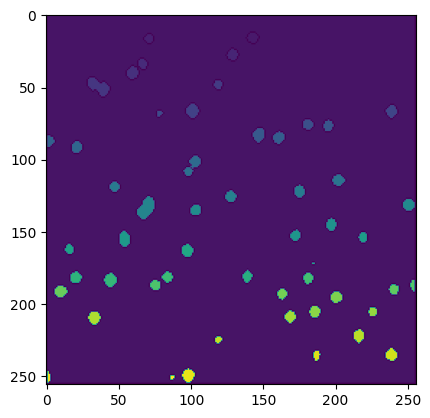

In [82]:
out =  watershed_segmentation(pred*255)
plt.imshow(out)

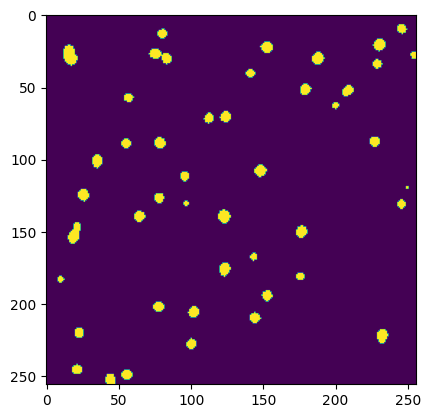

In [167]:
plt.imshow(pred)

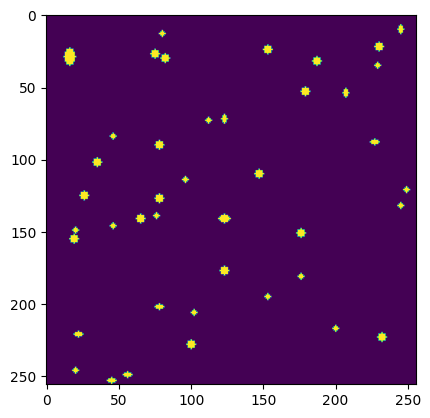

In [168]:
plt.imshow(gt_mask)

In [198]:
import cv2
import numpy as np

def watershed_instance_segmentation(binary_mask):
    """
    Perform watershed segmentation on a binary mask
    
    Args:
        binary_mask (np.ndarray): Binary mask (0,1)
    
    Returns:
        np.ndarray: Instance segmentation mask (0, 1, 2, 3...)
    """
    # Convert to 255 binary image
    thresh = (binary_mask * 255).astype(np.uint8)
    
    # Morphological opening to remove small noise
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Sure background
    sure_bg = cv2.dilate(opening, kernel, iterations=100)
    
    # Distance transform for foreground
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    
    # Foreground threshold (adjustable)
    ret, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # Unknown region
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Connected components markers
    ret, markers = cv2.connectedComponents(sure_fg)
    
    # Adjust markers
    markers = markers + 10
    markers[unknown == 255] = 0
    
    # Fake 3-channel image for watershed
    fake_rgb = np.zeros((*binary_mask.shape, 3), dtype=np.uint8)
    fake_rgb[:,:,0] = thresh
    
    # Watershed
    markers = cv2.watershed(fake_rgb, markers)
    
    return markers

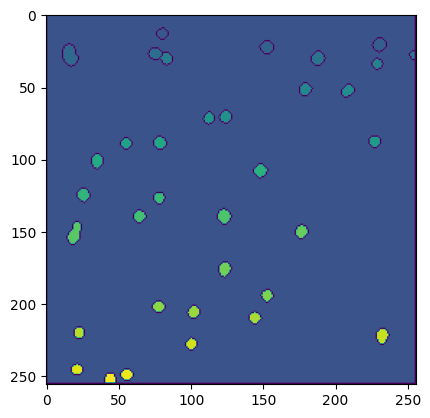

In [199]:
out = watershed_instance_segmentation(pred)
plt.imshow(out)

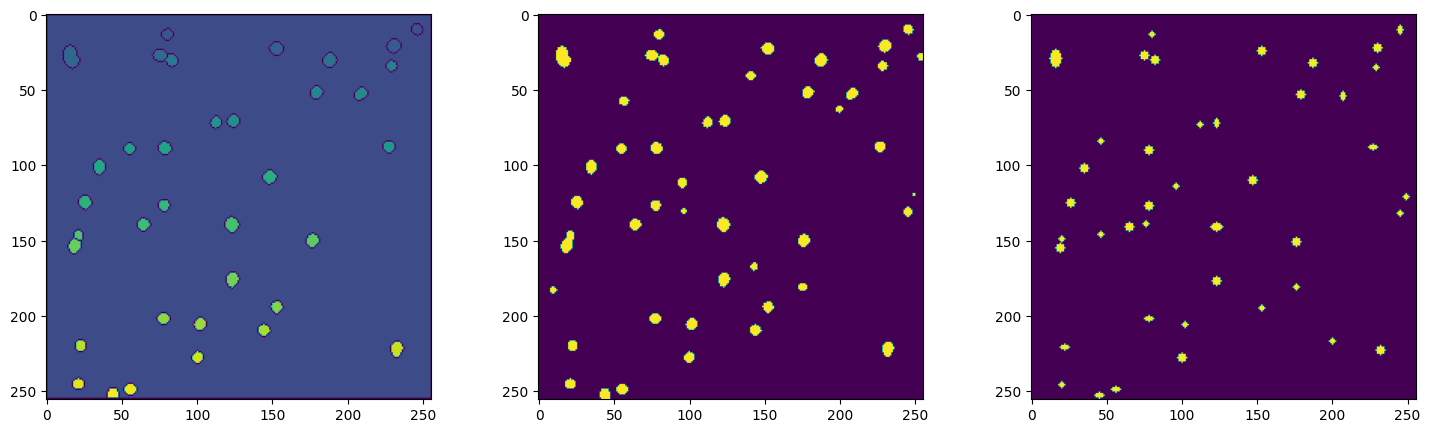

In [192]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.imshow(out)
ax3.imshow(gt_mask)
ax2.imshow(pred)